In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# C-TRUS Dataset: Exploratory Data Analysis

# importing libraries
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

In [ ]:
# loading metadata file
metadata_file = "/content/drive/MyDrive/c-trus/c-trus-main/c-trus.csv"
df = pd.read_csv(metadata_file)

# setting image and mask directories
image_dir = "/content/drive/MyDrive/c-trus/c-trus-main/original"
mask_dir = "/content/drive/MyDrive/c-trus/c-trus-main/labels"

# adding full image and mask paths using the correct 'file' column
df['image_path'] = df['file'].apply(lambda x: os.path.join(image_dir, x))
df['mask_path'] = df['file'].apply(lambda x: os.path.join(mask_dir, x))


df[['file', 'quality', 'image_path', 'mask_path']].head()

,file,quality,image_path,mask_path
0,9U3YBUK.jpg,1,/content/drive/MyDrive/c-trus/c-trus-main/orig...,/content/drive/MyDrive/c-trus/c-trus-main/labe...
1,E26MT6C.jpg,0,/content/drive/MyDrive/c-trus/c-trus-main/orig...,/content/drive/MyDrive/c-trus/c-trus-main/labe...
2,D1K2TQS.jpg,2,/content/drive/MyDrive/c-trus/c-trus-main/orig...,/content/drive/MyDrive/c-trus/c-trus-main/labe...
3,AQY3DE2.jpg,0,/content/drive/MyDrive/c-trus/c-trus-main/orig...,/content/drive/MyDrive/c-trus/c-trus-main/labe...
4,72EFRJV.jpg,1,/content/drive/MyDrive/c-trus/c-trus-main/orig...,/content/drive/MyDrive/c-trus/c-trus-main/labe...


In [ ]:
print("Image path exists:", os.path.exists(df['image_path'][0]))
print("Mask path exists:", os.path.exists(df['mask_path'][0]))


Image path exists: True
Mask path exists: True


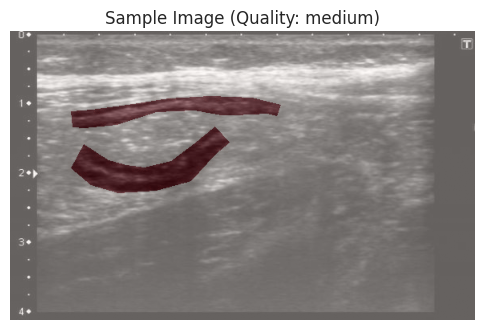

In [ ]:
img_path = df['image_path'][0]
mask_path = df['mask_path'][0]

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

if img is not None and mask is not None:
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, cmap='Reds', alpha=0.4)
    plt.title(f"Sample Image (Quality: {df['quality_name'][0]})")
    plt.axis('off')
    plt.show()
else:
    print("Could not load image or mask. Double-check file paths:")
    print("Image path exists?", os.path.exists(img_path))
    print("Mask path exists?", os.path.exists(mask_path))


/tmp/ipython-input-43-758259406.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="quality_name", order=["low", "medium", "high"], palette="pastel")


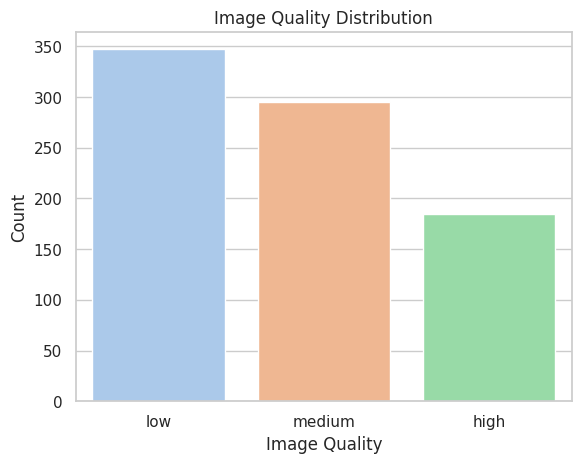

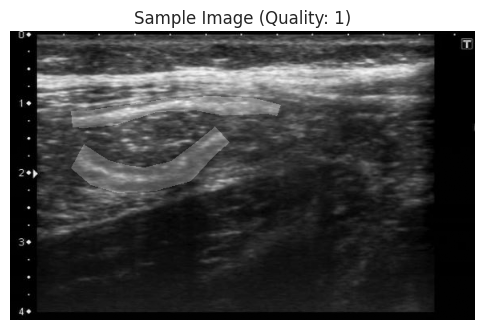

/tmp/ipython-input-43-758259406.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="quality_name",order=["low", "medium", "high"], y="mask_area", palette="Set2")


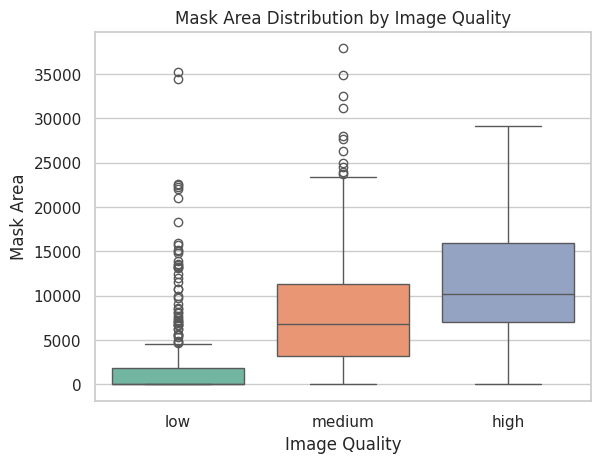

In [ ]:

# plotting image quality distribution
sns.countplot(data=df, x="quality_name", order=["low", "medium", "high"], palette="pastel")
plt.title("Image Quality Distribution")
plt.xlabel("Image Quality")
plt.ylabel("Count")
plt.show()

# checking sample image and mask overlay
img = cv2.imread(df['image_path'][0], cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(df['mask_path'][0], cv2.IMREAD_GRAYSCALE)
overlay = cv2.addWeighted(img, 0.8, mask, 0.2, 0)

plt.figure(figsize=(6, 6))
plt.imshow(overlay, cmap='gray')
plt.title(f"Sample Image (Quality: {df['quality'][0]})")
plt.axis('off')
plt.show()

# calculating mask area
df['mask_area'] = df['mask_path'].apply(lambda path: np.sum(cv2.imread(path, cv2.IMREAD_GRAYSCALE) > 0))

# boxplot of mask area by image quality
sns.boxplot(data=df, x="quality_name",order=["low", "medium", "high"], y="mask_area", palette="Set2")
plt.title("Mask Area Distribution by Image Quality")
plt.xlabel("Image Quality")
plt.ylabel("Mask Area")
plt.show()


In [ ]:
df['quality_name'].value_counts() #checking count to make sure it matches with github amount


,count
quality_name,
low,347
medium,295
high,185


In [ ]:
df[df['quality_name'] == 'low']['mask_area'].describe() #checking to see why 0 vals are found in the boxplot as that would mean there was no masking associated with the image


,mask_area
count,347.000000
mean,2084.616715
std,4911.528280
min,0.000000
25%,0.000000
50%,0.000000
75%,1845.500000
max,35195.000000


In [ ]:
(df['mask_area'] == 0).groupby(df['quality_name']).sum() #checking to see how many 'empty' masking images there are in each category of image quality


,mask_area
quality_name,
high,15
low,254
medium,50


In [ ]:
# showing the difference that zero values make
df_original = df.copy()
df_filtered = df[df['mask_area'] > 0].copy()
# creating label for the two dataaframes for reference
df_original['source'] = 'All masks'
df_filtered['source'] = 'Filtered masks (area > 0)'
# combining both the dataframes
df_combined = pd.concat([df_original, df_filtered])


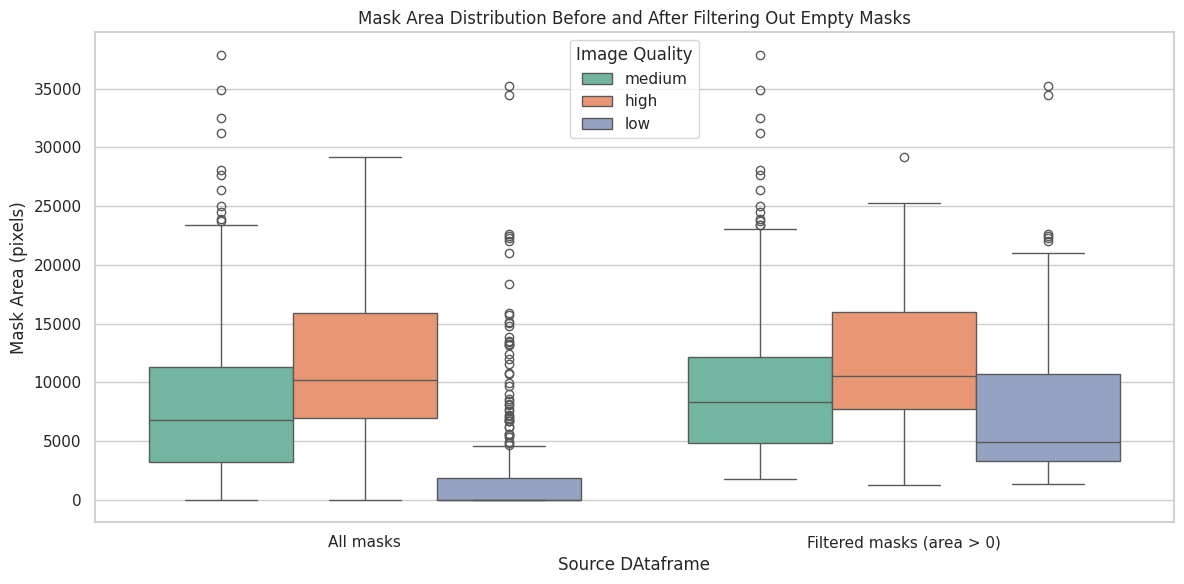

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_combined,
    x='source',               # two boxes: All masks, Filtered masks
    y='mask_area',            # the height of each box
    hue='quality_name',       # separate by image quality (low, medium, high)
    palette='Set2'            # color scheme
)
plt.title("Mask Area Distribution Before and After Filtering Out Empty Masks")
plt.xlabel("Source DAtaframe")
plt.ylabel("Mask Area (pixels)")
plt.legend(title="Image Quality")
plt.tight_layout()
plt.show()


/tmp/ipython-input-31-1801131622.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df[df['mask_area'] > 0].groupby('quality_name', group_keys=False).apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)


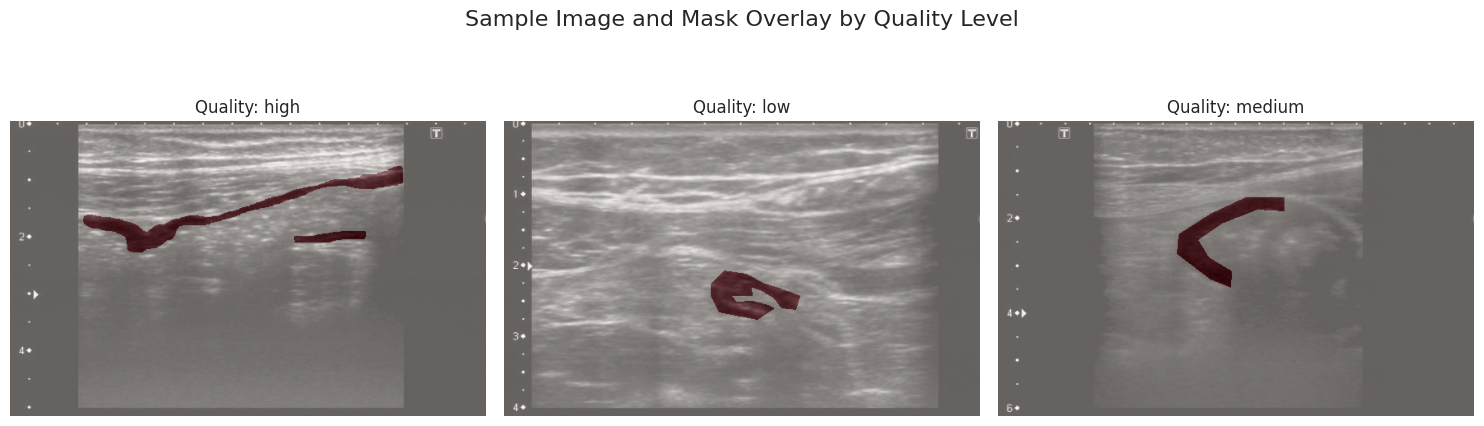

In [ ]:
#filter dataset to only include rows where the segmentation task is not zero (empty)
sample_df = df[df['mask_area'] > 0].groupby('quality_name', group_keys=False).apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

# load and display samples with empty lsts
sample_images = []
sample_masks = []
titles = [] #for quality naming
# og over the sample images and make sure both files load (image and mask)
for _, row in sample_df.iterrows():
    img = cv2.imread(row['image_path'], cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)

    if img is not None and mask is not None: #so it only proceeds if both files are found
        sample_images.append(img)
        sample_masks.append(mask)
        titles.append(f"Quality: {row['quality_name']}")
    else:
        print(f"Could not load image or mask for {row['file']}")

# plotting side-by-side overlays
fig, axs = plt.subplots(1, len(sample_images), figsize=(15, 5)) #three plots (one for each quality name)
for i in range(len(sample_images)):
    axs[i].imshow(sample_images[i], cmap='gray')
    axs[i].imshow(sample_masks[i], cmap='Reds', alpha=0.4)
    axs[i].set_title(titles[i])
    axs[i].axis('off')

plt.suptitle("Sample Image and Mask Overlay by Quality Level", fontsize=16)
plt.tight_layout()
plt.show()

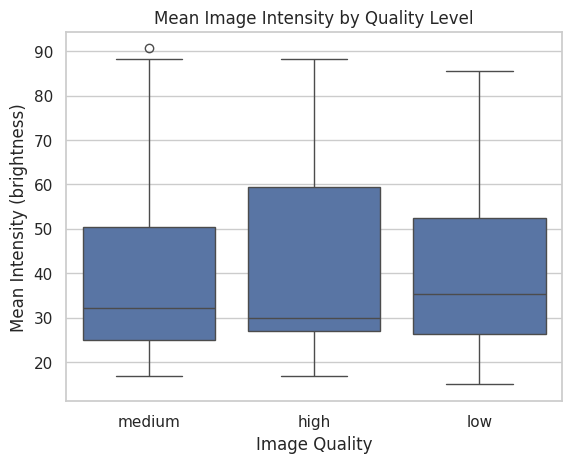

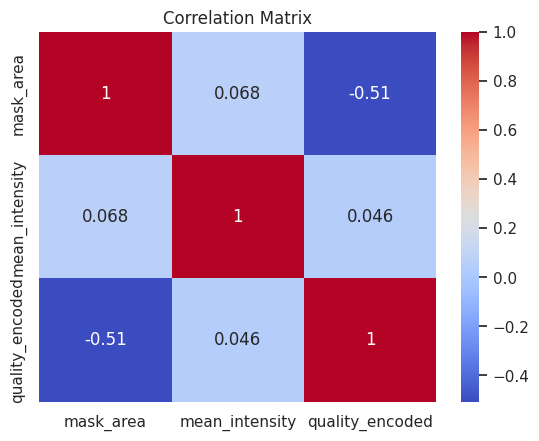

In [ ]:
# want to get info on the images so will use pixel intensity to evaluate brightness
df['mean_intensity'] = df['image_path'].apply(lambda p: np.mean(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) if os.path.exists(p) else np.nan) #to make sure that it doesnt give error results
sns.boxplot(data=df, x='quality_name', y='mean_intensity')
plt.title("Mean Image Intensity by Quality Level")
plt.xlabel("Image Quality")
plt.ylabel("Mean Intensity (brightness)")
plt.show()

# correlation anaysis - need numbers but dont want to change the input so i just mapped it to the same vals as quality column in C-TRUS
df['quality_encoded'] = df['quality_name'].map({'high': 0, 'medium': 1, 'low': 2})
sns.heatmap(df[['mask_area', 'mean_intensity', 'quality_encoded']].corr(), annot=True, cmap='coolwarm') # coolwarm to show pos and neg while also showing the vals in the box
plt.title("Correlation Matrix")
plt.show()

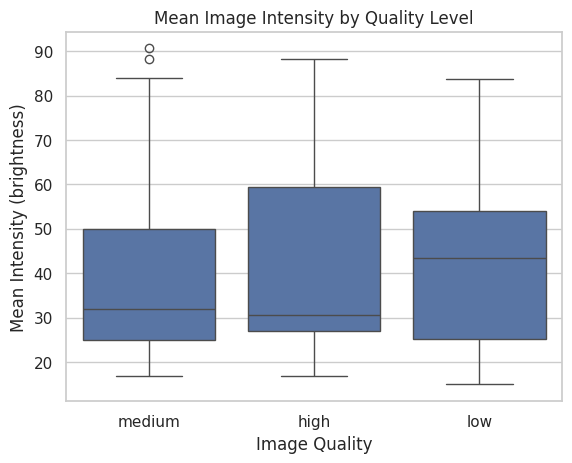

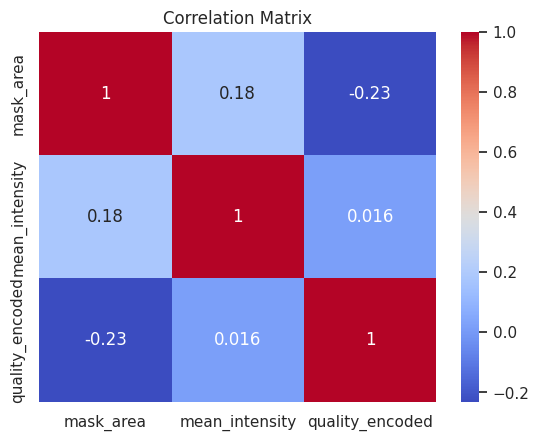

In [ ]:
# tested using the  filtered version of C-TRUS to make sure the 0 vals do not mess with the results
df_filtered = df[df['mask_area'] > 0].copy() #same as previous one

# want to get info on the images so will use pixel intensity to evaluate brightness
df_filtered['mean_intensity'] = df_filtered['image_path'].apply(lambda p: np.mean(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) if os.path.exists(p) else np.nan) #to make sure that it doesnt give error results
sns.boxplot(data=df_filtered, x='quality_name', y='mean_intensity')
plt.title("Mean Image Intensity by Quality Level")
plt.xlabel("Image Quality")
plt.ylabel("Mean Intensity (brightness)")
plt.show()

# correlation anaysis - need numbers but dont want to change the input so i just mapped it to the same vals as quality column in C-TRUS
df_filtered['quality_encoded'] = df_filtered['quality_name'].map({'high': 0, 'medium': 1, 'low': 2})
sns.heatmap(df_filtered[['mask_area', 'mean_intensity', 'quality_encoded']].corr(), annot=True, cmap='coolwarm') # coolwarm to show pos and neg while also showing the vals in the box
plt.title("Correlation Matrix")
plt.show()
